In [ ]:
# Unet 3 p with attention - RE-ARCH

In [1]:
# DO 

!pip uninstall Albumentations
!pip install Albumentations==0.5.2

In [ ]:
# Dice link: https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388

In [211]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm
import time
import random

plt.style.use("dark_background")
%matplotlib inline


In [212]:
BASE_PATH= "/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m"

In [213]:
"/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif"

'/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif'

In [214]:
BASE_LEN = len(BASE_PATH) + len("/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_")
END_LEN = len(".tif")
END_MASK_LEN = len("_mask.tif")

IMG_SIZE = 512

# Prepare data

In [215]:
data = []

for dir_ in os.listdir(BASE_PATH):
    dir_path = os.path.join(BASE_PATH, dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"[INFO] This is not a dir --> {dir_path}")
        
df = pd.DataFrame(data, columns=["dir_name", "image_path"])


[INFO] This is not a dir --> /Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/data.csv
[INFO] This is not a dir --> /Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/README.md


In [216]:
df

,dir_name,image_path
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
...,...,...
7853,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7854,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7855,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7856,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...


In [217]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [218]:
df_imgs.iloc[0,1][BASE_LEN: -END_LEN]

'9'

In [219]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int((x[BASE_LEN: -END_LEN])))
masks = sorted(df_masks["image_path"].values, key=lambda x: int((x[BASE_LEN: -END_MASK_LEN])))

In [220]:
# sanity check
idx = random.randint(0, len(imgs)-1)
print(f"This image *{imgs[idx]}*\n Belongs to the mask *{masks[idx]}*")

This image */Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_4.tif*
 Belongs to the mask */Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_4_mask.tif*


In [221]:
# final dataframe
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})

dff.head()

,patient,image_path,mask_path
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...


In [222]:
dff.iloc[0,1]

'/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1.tif'

In [223]:
dff.iloc[0,2]


'/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1_mask.tif'

In [224]:
def pos_neg_diagnosis(mask_path):
    val = np.max(cv2.imread(mask_path))
    if val > 0: return 1
    else: return 0

In [225]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

dff.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0


In [226]:
dff.shape


(3929, 4)

In [227]:
dff.diagnosis.value_counts()

0    2556
1    1373
Name: diagnosis, dtype: int64

In [228]:
print("Amount of patients: ", len(set(dff.patient)))
print("Amount of records: ", len(dff))

Amount of patients:  110
Amount of records:  3929


# Data Augmentation

In [229]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor

from sklearn.model_selection import train_test_split

In [230]:
import platform
import sklearn as sk
import sys
has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.0.1-arm64-arm-64bit
PyTorch Version: 1.12.1

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Pandas 1.5.1
Scikit-Learn 1.1.3
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [231]:
class BrainMRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        
        augmented = self.transform(image=image,
                                   mask=mask)
        
        image = augmented["image"]
        mask = augmented["mask"]
#         mask = np.expand_dims(augmented["mask"], axis=0)# Do not use this
        
        return image, mask

In [232]:
PATCH_SIZE = 128

transform = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(p=1.0),
    ToTensorV2(),
    
])

# Split Data and DataLoaders

In [233]:
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [234]:
train_dataset = BrainMRIDataset(train_df, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = BrainMRIDataset(val_df, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=10,  shuffle=True)

test_dataset = BrainMRIDataset(test_df, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=10,shuffle=True)

In [235]:
len(train_dataset)

3111

In [236]:
len(val_dataset)

393

In [237]:
len(test_dataset)

425

In [238]:
def show_aug(inputs, nrows=5, ncols=5, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

torch.Size([10, 3, 128, 128]) torch.Size([10, 1, 128, 128])


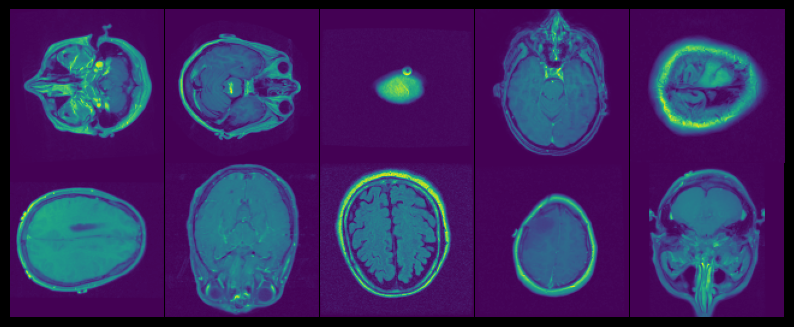

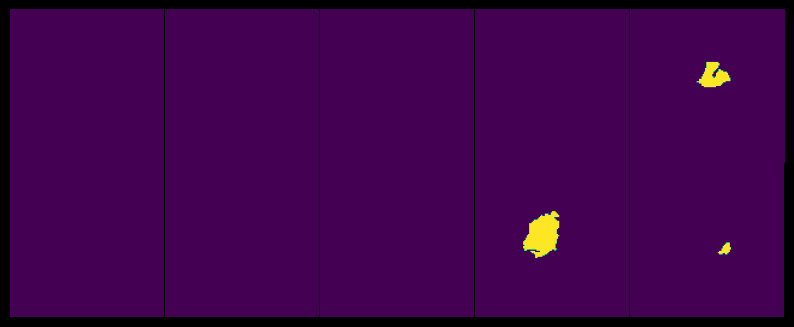

In [239]:
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, norm=False)

In [240]:
# ATTENTION UNET

In [241]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(ch_out, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x



In [242]:
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

In [243]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x

In [244]:
#MODEL

In [245]:
# check sanity
output = torch.randn(1,3,256,256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

In [246]:
#UNET 3+ with attention

In [247]:
import torch
import torch.nn as nn
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [248]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

In [249]:
'''
    UNet 3+ with attention
'''
class UNet_3Plus_attn(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
        super(UNet_3Plus_attn, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)
        self.att4 = AttentionBlock(f_g=256, f_l=64, f_int=256)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)
        

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
#         self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
# modified
#         self.conv4d_1 = nn.Conv2d(128, self.UpChannels, 3, padding=1)  # 16 # if only 2 inputs concatenated(each input 64 size) 
        self.conv4d_1 = nn.Conv2d(384, self.UpChannels, 3, padding=1)  # 16 (6*64 = 384)
    
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        self.att3 = AttentionBlock(f_g=256, f_l=64, f_int=256)
        
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(384, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        self.att2 = AttentionBlock(f_g=256, f_l=64, f_int=256)
        
        
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(384, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        self.att1 = AttentionBlock(f_g=256, f_l=64, f_int=256)
        
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(384, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # output
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
# #         modified
        temp_cat4 = torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4), 1)
        outatt4 = self.att4(g=temp_cat4, x=hd5_UT_hd4)
#         print("outatt4", outatt4.shape)
#         print("hd5_UT_hd4", hd5_UT_hd4.shape)
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
            torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, outatt4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels
#         hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
#             torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels
#         print("h4_Cat_hd4", h4_Cat_hd4.shape)
#         print("hd5_UT_hd4", hd5_UT_hd4.shape)
#         print("cat shape", torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1).shape)
#         print("hd4 shape", hd4.shape)
        
# h4_Cat_hd4 torch.Size([26, 64, 16, 16])
# hd5_UT_hd4 torch.Size([26, 64, 16, 16])
# cat shape torch.Size([26, 320, 16, 16])
# hd4 shape torch.Size([26, 320, 16, 16])

        
        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        temp_cat3 = torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd5_UT_hd3), 1)
        outatt3 = self.att3(g=temp_cat3, x=hd4_UT_hd3)
#         print("outatt4", outatt4.shape)
#         print("hd5_UT_hd4", hd5_UT_hd4.shape)
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, outatt3, hd5_UT_hd3), 1))))
#         hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
#             torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        temp_cat2 = torch.cat((h1_PT_hd2, h2_Cat_hd2, hd5_UT_hd2, hd4_UT_hd2), 1)
        outatt2 = self.att2(g=temp_cat2, x=hd3_UT_hd2)
#         hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
#             torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, outatt2, hd5_UT_hd2), 1))))

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
#         hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
#             torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels
        temp_cat1 = torch.cat((h1_Cat_hd1, hd5_UT_hd1, hd3_UT_hd1, hd4_UT_hd1), 1)
        outatt1 = self.att1(g=temp_cat1, x=hd2_UT_hd1)
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, outatt1, hd5_UT_hd1), 1))))
        
        d1 = self.outconv1(hd1)  # d1->320*320*n_classes
        return F.sigmoid(d1)

In [250]:
unet3p_attn = UNet_3Plus_attn(n_classes=1).to(device)

In [251]:
#SEGMENTATION METRIC

In [252]:
def dice_coef_metric(inputs, target): # ORIGINAL
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

In [253]:
# def dice_coef_metric(y_true, y_pred, smooth=1):
#     y_true_f = torch.flatten(torch.tensor(y_true))
#     y_pred_f = torch.flatten(torch.tensor(y_pred))

#     intersection = (y_true_f * y_pred_f).view(-1).sum()
#     sums = (y_true_f).view(-1).sum() + (y_pred_f).view(-1).sum()

#     return (2*intersection + smooth) / (sums + intersection + smooth)

In [254]:
#Segmentation Loss

In [255]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [256]:
# sanity check
DiceLoss()(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.0448)

In [257]:
# Training

In [258]:
PATH = "model_unet_3p_attn.pt"



In [259]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': np.array(losses).mean(),
                    }, PATH)
        
#         print("losses:", np.array(losses))
#         print("iou:", np.array(train_iou))
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [260]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [261]:
opt = torch.optim.Adamax(unet3p_attn.parameters(), lr=1e-3)

In [262]:
# %%time
num_ep = 1
# after 30 does not improve much

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet 3p attn", unet3p_attn, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)

[INFO] Model is initializing... UNet 3p attn


  0%|          | 0/312 [00:00<?, ?it/s]

/Users/srikeshnagoji/miniforge3/envs/capstone/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [0]
Mean loss on train: -0.7561115918633265 
Mean DICE on train: 0.92710054 
Mean DICE on validation: tensor(0.9427)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: -0.8031497760078846 
Mean DICE on train: 0.94412446 
Mean DICE on validation: tensor(0.9492)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: -0.7744411159402285 
Mean DICE on train: 0.9304512 
Mean DICE on validation: tensor(0.9715)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: -0.8117351541534449 
Mean DICE on train: 0.94286454 
Mean DICE on validation: tensor(0.9264)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: -0.8136321934751976 
Mean DICE on train: 0.9438919 
Mean DICE on validation: tensor(0.9325)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: -0.8312240369044818 
Mean DICE on train: 0.9482121 
Mean DICE on validation: tensor(0.9847)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: -0.8337533311584057 
Mean DICE on train: 0.9481714 
Mean DICE on validation: tensor(0.9927)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: -0.8279909663475477 
Mean DICE on train: 0.9430267 
Mean DICE on validation: tensor(0.9327)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: -0.8554245609885607 
Mean DICE on train: 0.9562419 
Mean DICE on validation: tensor(0.9299)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: -0.8314336733176158 
Mean DICE on train: 0.9438614 
Mean DICE on validation: tensor(0.9938)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: -0.8623536420174134 
Mean DICE on train: 0.9565371 
Mean DICE on validation: tensor(0.9674)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: -0.869841184753638 
Mean DICE on train: 0.9590575 
Mean DICE on validation: tensor(0.9802)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: -0.8776026857204926 
Mean DICE on train: 0.95821166 
Mean DICE on validation: tensor(0.9736)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: -0.8701729270128103 
Mean DICE on train: 0.9534486 
Mean DICE on validation: tensor(0.9928)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: -0.8539048148653446 
Mean DICE on train: 0.94898164 
Mean DICE on validation: tensor(0.9711)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: -0.8672164959403185 
Mean DICE on train: 0.95244586 
Mean DICE on validation: tensor(1.0051)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: -0.8882072902260683 
Mean DICE on train: 0.9634726 
Mean DICE on validation: tensor(0.9460)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: -0.8943026344745587 
Mean DICE on train: 0.96344775 
Mean DICE on validation: tensor(1.0056)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: -0.8672715127468109 
Mean DICE on train: 0.9507687 
Mean DICE on validation: tensor(0.9995)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: -0.8902172835973593 
Mean DICE on train: 0.96055347 
Mean DICE on validation: tensor(0.9179)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: -0.9006926419261174 
Mean DICE on train: 0.9679329 
Mean DICE on validation: tensor(0.9746)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: -0.9076377518284016 
Mean DICE on train: 0.9703477 
Mean DICE on validation: tensor(0.9812)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: -0.9091065569947927 
Mean DICE on train: 0.9688167 
Mean DICE on validation: tensor(1.0093)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: -0.8905507211501782 
Mean DICE on train: 0.9603249 
Mean DICE on validation: tensor(0.9577)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: -0.9092300201837833 
Mean DICE on train: 0.9688939 
Mean DICE on validation: tensor(0.9506)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: -0.8961480641976382 
Mean DICE on train: 0.95970035 
Mean DICE on validation: tensor(0.9616)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: -0.9019678685909662 
Mean DICE on train: 0.96809155 
Mean DICE on validation: tensor(1.0036)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: -0.9168966672359369 
Mean DICE on train: 0.9707724 
Mean DICE on validation: tensor(1.0118)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: -0.9289682677541024 
Mean DICE on train: 0.97839123 
Mean DICE on validation: tensor(0.9781)


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: -0.8984023303939745 
Mean DICE on train: 0.9638109 
Mean DICE on validation: tensor(0.9627)


In [263]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()

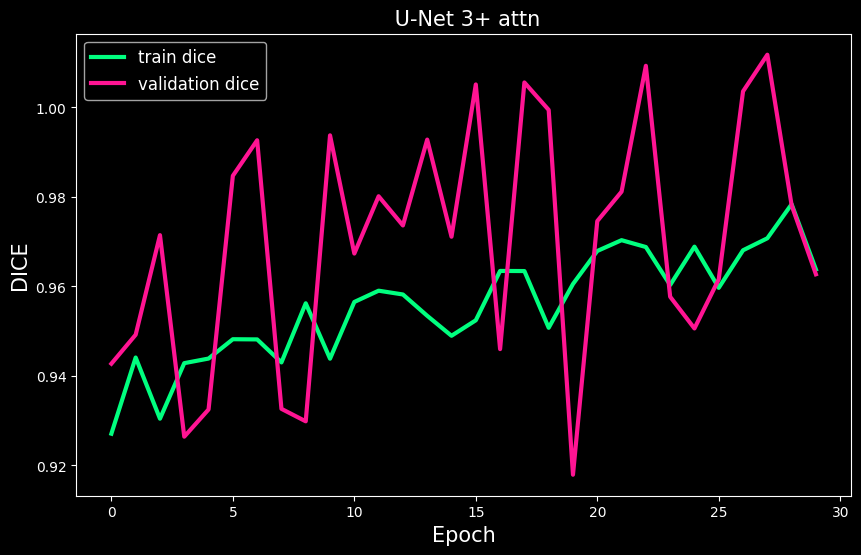

In [264]:
plot_model_history(" U-Net 3+ attn", aun_th, aun_vh, num_ep)

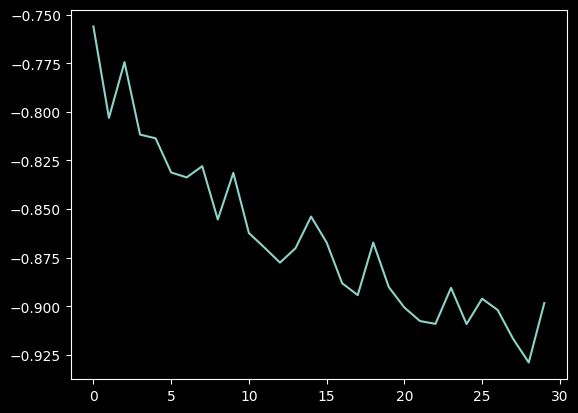

In [265]:
plt.plot(range(num_ep), aun_lh)

In [266]:
test_iou = compute_iou(unet3p_attn, test_dataloader)
print(f"""Attention U-Net\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

Attention U-Net
Mean IoU of the test images - 99.0%


In [267]:
#============================== EXP : viz pred mask

In [268]:
# a = torch.zeros(4, 5, 6)
# a = a.unsqueeze(0)

# a.shape


In [269]:
test_dataset.df.head(10)#[test_dataset.df['diagnosis']==1]

,patient,image_path,mask_path,diagnosis
163,TCGA_FG_7634_20000128,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1073,TCGA_HT_7693_19950520,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
557,TCGA_FG_8189_20030516,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1103,TCGA_FG_7643_20021104,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
2610,TCGA_HT_A61A_20000127,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
631,TCGA_DU_A5TW_19980228,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
261,TCGA_DU_5851_19950428,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
917,TCGA_DU_8162_19961029,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,1
1111,TCGA_DU_7018_19911220,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1426,TCGA_DU_8167_19970402,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0


In [275]:
test_dataset.df.loc[1103]

patient                                   TCGA_FG_7643_20021104
image_path    /Users/srikeshnagoji/Documents/PythonWorkSpace...
mask_path     /Users/srikeshnagoji/Documents/PythonWorkSpace...
diagnosis                                                     1
Name: 1103, dtype: object

In [276]:
test_dataset[1][1].sum()

0

In [277]:
# def viz_pred_output(model, loader, threshold=0.3):
#     valloss = 0
    
#     with torch.no_grad():

#         for i_step, (data, target) in enumerate(loader):
            
#             data = data[0].to(device).unsqueeze(0)
#             target = target[0].to(device).unsqueeze(0)
            
#             outputs = model(data)

#             out_cut = np.copy(outputs.data.cpu().numpy())
#             out_cut[np.nonzero(out_cut < threshold)] = 0.0
#             out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            
#             f, axarr = plt.subplots(1,2)
# #             axarr[0,0].imshow(image_datas[0])
# #             axarr[0,1].imshow(image_datas[1])
            
#             targ = target.data.cpu().numpy()[0][0]
#             target_img = cv2.merge((targ,targ,targ))
#             axarr[0].imshow(target_img)
            
#             op = out_cut[0][0]
#             axarr[1].imshow(op)
            
#             break


def viz_pred_output(model, loader, idx,  threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

#         for i_step, (data, target) in enumerate(loader):
        target = torch.tensor(test_dataset[idx][1])
        data = torch.tensor(test_dataset[idx][0])

        data = data.to(device).unsqueeze(0)
        target = target.to(device).unsqueeze(0)

        outputs = model(data)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < threshold)] = 0.0
        out_cut[np.nonzero(out_cut >= threshold)] = 1.0

        f, axarr = plt.subplots(1,2)
#             axarr[0,0].imshow(image_datas[0])
#             axarr[0,1].imshow(image_datas[1])

        targ = target.data.cpu().numpy()[0][0]
        target_img = cv2.merge((targ,targ,targ))
        axarr[0].imshow(target_img)

        op = out_cut[0][0]
        axarr[1].imshow(op)




<ipython-input-277-f2400c6dc5e1>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(test_dataset[idx][0])


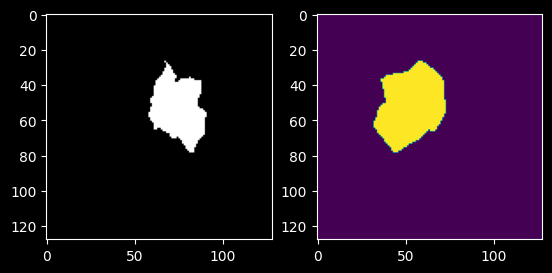

In [285]:
idx = 33
viz_pred_output(unet3p_attn, test_dataloader, idx)

In [191]:
#==============================

In [109]:
# Different Loss Functions and Comparisons

In [110]:
#TODO: copy paste

In [111]:
# For 5 epochs

In [112]:
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

In [113]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [114]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [115]:
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

#=====
#Multi-class Lovasz loss
#=====

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)

class LovaszHingeLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LovaszHingeLoss, self).__init__()

    def forward(self, inputs, targets):
        inputs = F.sigmoid(inputs)    
        Lovasz = lovasz_hinge(inputs, targets, per_image=False)                       
        return Lovasz

<>:100: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:100: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-115-85384459795b>:100: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):


In [116]:
# Focal loss

In [ ]:
%%time
num_ep = 5

aun_lh2, aun_th2, aun_vh2 = train_model("Attention UNet3+",  unet3p_attn, train_dataloader, val_dataloader, FocalLoss(), opt, False, num_ep)

In [ ]:
plot_model_history("Focal Loss Attention U-Net 3+", aun_th2, aun_vh2, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh2)

In [117]:
# Focal Tversky Loss

In [ ]:
%%time
num_ep = 5

aun_lh3, aun_th3, aun_vh3 = train_model("Attention UNet3+",  unet3p_attn, train_dataloader, val_dataloader, FocalTverskyLoss(), opt, False, num_ep)

In [ ]:
plot_model_history("Focal Tversky Loss Attention U-Net 3+", aun_th3, aun_vh3, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh3)